# Q5: Analysis (20 points)
By now you should know how to train networks from scratch or using from pre-trained models. You should also understand the relative performance in either scenarios. Needless to say, the performance of these models is stronger than previous non-deep architectures used until 2012. However, final performance is not the only metric we care about. It is important to get some intuition of what these models are really learning. Lets try some standard techniques.


**FEEL FREE TO WRITE UTIL CODE IN ANOTHER FILE AND IMPORT IN THIS NOTEBOOK FOR EASE OF READABILITY**

## 5.1 Nearest Neighbors (7 pts)
Pick 3 images from PASCAL test set from different classes, and compute 4 nearest neighbors over the entire test set for each of them. You should compare the following feature representations to find the nearest neighbors:
1. The features before the final fc layer from the ResNet (finetuned from ImageNet). It is the features right before the final class label output.
2. pool5 features from the CaffeNet (trained from scratch)

You may use the [this nearest neighbor function](https://scikit-learn.org/stable/modules/neighbors.html).
Plot the raw images of the ones you picked and their nearest neighbors.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!tar -xf VOCtrainval_06-Nov-2007.tar

!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar 
!tar -xf VOCtest_06-Nov-2007.tar

--2022-03-01 02:53:29--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  22.1MB/s    in 21s     

2022-03-01 02:53:50 (20.9 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

--2022-03-01 02:53:52--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451020800 (430M) [application/x-tar]
Saving to: ‘VOCtest_06-Nov-2007.tar’

VOCtest_06-Nov-2007 100%[===================

In [3]:
%cd drive/MyDrive/spring22/16824/hw1

/content/drive/MyDrive/spring22/16824/hw1


In [19]:
%load_ext autoreload
%autoreload 2

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import trainer

from collections import OrderedDict
from torchvision import models
from utils import ARGS, get_data_loader, eval_dataset_map
from voc_dataset import VOCDataset

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def load_model(model, filepath):
    model.load_state_dict(torch.load(filepath))

    return model

def get_layer_features(model, layer_name):

    test_loader = get_data_loader(train=False,
                                  batch_size=100,
                                  split='test')

    layer_features = []

    for data, target, wgt in test_loader:

        # Calculate the features for all the test images. 
        # Reshaping it to N x features
        output = model(data.to(device))
        layer_features.append(activation[layer_name].reshape(data.size(0),
                                                            -1))
        
        del activation[layer_name]
        del output
    
    # Getting the features stored in the activation dict. Triggered due to the 
    # forward hook.
    return torch.cat(layer_features)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
class CaffeNet(nn.Module):
    def __init__(self, num_classes=20, inp_size=224, c_dim=3):
        super().__init__()
        
        self.conv1 = nn.Conv2d(c_dim, 96, 11, stride=4, padding='valid')
        self.pool1 = nn.MaxPool2d(3, stride=2)

        self.conv2 = nn.Conv2d(96, 256, 5, padding='same')
        self.pool2 = nn.MaxPool2d(3, stride=2)

        self.conv3 = nn.Conv2d(256, 384, 3, padding='same')
        self.conv4 = nn.Conv2d(384, 384, 3, padding='same')
        self.conv5 = nn.Conv2d(384, 256, 3, padding='same')
        self.pool5 = nn.MaxPool2d(3, stride=2)

        init_kernel = lambda x: int(math.floor((x - 11) / 4.) + 1.)
        kernel_post_pool = lambda x: int(math.floor((x - 3) / 2.) + 1.)
        kernel_post_all_pool = lambda x: kernel_post_pool(
            kernel_post_pool(kernel_post_pool(x)))
        final_conv_dim = kernel_post_all_pool(init_kernel(inp_size))

        # print(init_kernel(inp_size))
        # print(kernel_post_all_pool(init_kernel(inp_size)))

        self.flat_dim = final_conv_dim * final_conv_dim * 256

        self.fc1 = nn.Linear(self.flat_dim, 4096)
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(4096, 4096)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(4096, 20)

        self.__init_weights__()
    
    def forward(self, x):
        
        out = self.pool1(F.relu(self.conv1(x)))
        out = self.pool2(F.relu(self.conv2(out)))
        out = F.relu(self.conv4(F.relu(self.conv3(out))))
        out = self.pool5(F.relu(self.conv5(out)))

        out = out.view(out.size(0), self.flat_dim)
        out = self.dropout1(F.relu(self.fc1(out)))
        out = self.dropout2(F.relu(self.fc2(out)))

        out = self.fc3(out)

        return out
    
    def __init_weights__(self):
        nn.init.xavier_uniform_(self.conv1.weight)
        nn.init.xavier_uniform_(self.conv2.weight)
        nn.init.xavier_uniform_(self.conv3.weight)
        nn.init.xavier_uniform_(self.conv4.weight)
        nn.init.xavier_uniform_(self.conv5.weight)

class PretrainedResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet18(pretrained=True)
        n_inputs = self.resnet.fc.in_features

        # Initializing a new final layer.
        classifier = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(n_inputs, 20))
        ]))
        self.resnet.fc = classifier
    
    def forward(self, x):

        # Just running the entire model on the data.
        return self.resnet(x)

In [16]:
def view_nearest_neighbors(model, ckpt_path, layer_name):

    device = torch.device("cuda")

    model = load_model(model, ckpt_path)
    model.eval()

    # Load all the test images. Pick 3 indices.
    dataset = VOCDataset('test', 224, perform_transforms=False)

    total_test_images = len(dataset)
    indices = torch.randint(high=total_test_images, size=(3,))
    
    # Getting the features stored in the activation dict. Triggered due to the 
    # forward hook. Reshaping it to N x features
    last_features = get_layer_features(model, layer_name)

    for i in indices:

        # Fine the nearest neighbors for the 3 images you picked.
        distances = torch.sum(torch.square(last_features - \
                                           last_features[i].reshape(1, -1)),
                              dim=1)
        nn_idx = torch.argsort(distances)[1:5]

        neighbor_images = [dataset[i][0] for i in nn_idx]

        # Plot the images and their neighbors.
        fig, axes = plt.subplots(nrows=1, ncols=5)
        fig.set_size_inches(20, 40)
        axes[0].imshow((torch.permute(dataset[i][0],
                                      dims=(1, 2, 0)).cpu().detach().numpy() \
                        * 255).astype(np.uint8))
        axes[0].axes.xaxis.set_visible(False)
        axes[0].axes.yaxis.set_visible(False)

        axes[1].imshow((torch.permute(neighbor_images[0],
                                      dims=(1, 2, 0)).cpu().detach().numpy() \
                        * 255).astype(np.uint8))
        axes[1].axes.xaxis.set_visible(False)
        axes[1].axes.yaxis.set_visible(False)
        
        axes[2].imshow((torch.permute(neighbor_images[1],
                                      dims=(1, 2, 0)).cpu().detach().numpy() \
                        * 255).astype(np.uint8))
        axes[2].axes.xaxis.set_visible(False)
        axes[2].axes.yaxis.set_visible(False)
        
        axes[3].imshow((torch.permute(neighbor_images[2],
                                      dims=(1, 2, 0)).cpu().detach().numpy() \
                        * 255).astype(np.uint8))
        axes[3].axes.xaxis.set_visible(False)
        axes[3].axes.yaxis.set_visible(False)

        axes[4].imshow((torch.permute(neighbor_images[3],
                                      dims=(1, 2, 0)).cpu().detach().numpy() \
                        * 255).astype(np.uint8))
        axes[4].axes.xaxis.set_visible(False)
        axes[4].axes.yaxis.set_visible(False)
        # plt.title('{}-{}'.format(layer_name, i))
        plt.show()

resnetCkpt = 'models/checkpoint-PretrainedResNet2-epoch10.pth'
caffeCkpt = 'models/checkpoint-CaffeNet15-epoch75.pth'
device = torch.device("cuda")

resnet = PretrainedResNet().to(device)

for name, module in resnet.named_modules():
    # print(name)
    if name == 'resnet.avgpool': 
        print('Registering avgpool hook')
        module.register_forward_hook(get_activation('avgpool'))

caffenet = CaffeNet().to(device)

for name, module in caffenet.named_modules():
    # print(name)
    if name == 'pool5': 
        print('Registering pool5 hook')
        module.register_forward_hook(get_activation('pool5'))

print('\nVisualizing ResNet')
view_nearest_neighbors(resnet, resnetCkpt, 'avgpool')

print('\nVisualizing CaffeNet')
view_nearest_neighbors(caffenet, caffeCkpt, 'pool5')

Output hidden; open in https://colab.research.google.com to view.

## 5.2 t-SNE visualization of intermediate features (7pts)
We can also visualize how the feature representations specialize for different classes. Take 1000 random images from the test set of PASCAL, and extract caffenet (scratch) fc7 features from those images. Compute a 2D [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) projection of the features, and plot them with each feature color coded by the GT class of the corresponding image. If multiple objects are active in that image, compute the color as the ”mean” color of the different classes active in that image. Legend the graph with the colors for each object class.

Registering fc2 hook


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


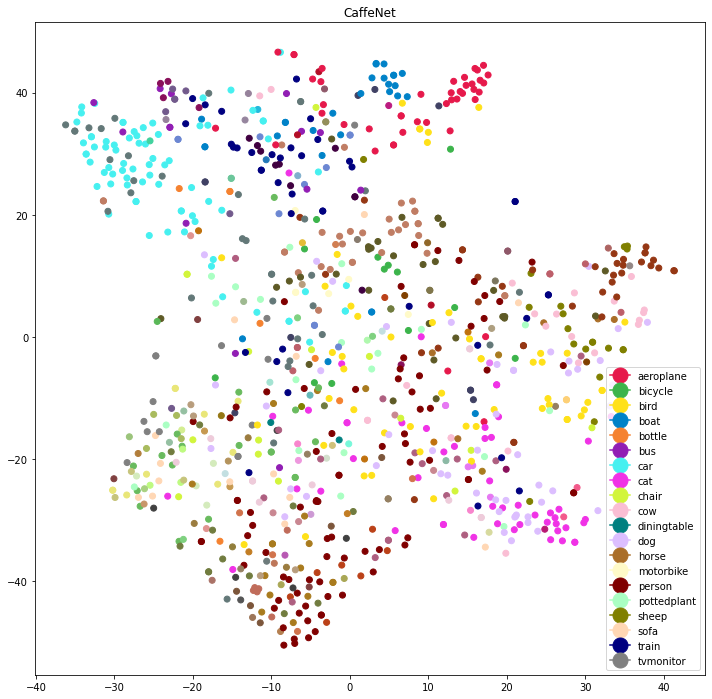

Registering resnet.avgpool hook


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


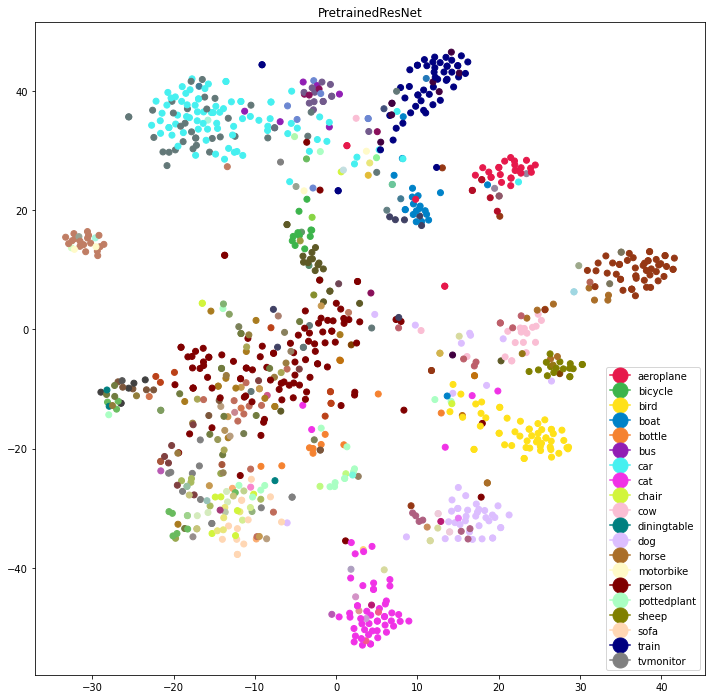

In [8]:
# plot t-SNE here
from sklearn.manifold import TSNE

def plot_tsne(model, ckptPath, model_name, layer_name):

    n_classes = 20
    
    dataset = VOCDataset('test', 224, perform_transforms=False)
    total_test_images = len(dataset)
    indices = torch.randint(high=total_test_images, size=(1000,))

    labels = []
    for i in indices:
        label = dataset[i][1]
        labels.append(label.reshape(1, n_classes))

    labels = torch.cat(labels)

    model = load_model(model, ckptPath)

    for name, module in model.named_modules():
        # FC7 is FC2 in my case.
        if name == layer_name: 
            print(f'Registering {layer_name} hook')
            module.register_forward_hook(get_activation(layer_name))

    layer_features = get_layer_features(model, layer_name)

    # Got the 1000 features from layer fc7.
    selected_features = layer_features[indices]

    # TSNE
    tsne = TSNE()
    embed_features = tsne.fit_transform(selected_features.cpu().detach().numpy())

    colors = ['#e6194b',
              '#3cb44b',
              '#ffe119',
              '#4363d8',
              '#f58231',
              '#911eb4',
              '#46f0f0',
              '#f032e6',
              '#bcf60c',
              '#fabebe',
              '#008080',
              '#e6beff',
              '#9a6324',
              '#fffac8',
              '#800000',
              '#aaffc3',
              '#808000',
              '#ffd8b1',
              '#000075',
              '#808080']
    colors_rgb = np.array([(230, 25, 75),
                          (60, 180, 75),
                          (255, 225, 25),
                          (0, 130, 200),
                          (245, 130, 48),
                          (145, 30, 180),
                          (70, 240, 240),
                          (240, 50, 230),
                          (210, 245, 60),
                          (250, 190, 212),
                          (0, 128, 128),
                          (220, 190, 255),
                          (170, 110, 40),
                          (255, 250, 200),
                          (128, 0, 0),
                          (170, 255, 195),
                          (128, 128, 0),
                          (255, 215, 180),
                          (0, 0, 128),
                          (128, 128, 128)])
    colors_rgb = colors_rgb / 255.

    feature_colors = np.matmul(labels.cpu().detach().numpy(), colors_rgb) / \
                    np.sum(labels.cpu().detach().numpy(), axis=1).reshape(-1, 1)

    custom_lines = []
    for i in range(20):
        custom_lines.append(plt.Line2D([0],
                                      [0],
                                      marker='o',
                                      color=colors_rgb[i],
                                      label=dataset.CLASS_NAMES[i],
                                      #  markerfacecolor=colors[0,i,:],
                                      markersize=15))

    # Plot the tsne features with colors
    plt.figure(figsize = (12,12))
    plt.scatter(embed_features[:, 0], embed_features[:, 1], c=feature_colors)
    plt.legend(handles=custom_lines)
    plt.title(model_name)
    plt.show()

caffeCkpt = 'models/checkpoint-CaffeNet15-epoch75.pth'
device = torch.device("cuda")
caffenet = CaffeNet().to(device)

# My FC2 is the actual FC7
plot_tsne(caffenet, caffeCkpt, 'CaffeNet', 'fc2')

resnetCkpt = 'models/checkpoint-PretrainedResNet2-epoch10.pth'
device = torch.device("cuda")
resnet = PretrainedResNet().to(device)

plot_tsne(resnet, resnetCkpt, 'PretrainedResNet', 'resnet.avgpool')

## 5.3 Are some classes harder? (6pts)
Show the per-class performance of your caffenet (scratch) and ResNet (finetuned) models. This is an open-ended question and you may use any performance metric that makes sense. Try to explain, by observing examples from the dataset, why some classes are harder or easier than the others (consider the easiest and hardest class). Do some classes see large gains due to pre-training? Can you explain why that might happen?

**YOUR ANSWER HERE**

In [32]:
def plot_AP(model, ckptPath, model_name):

    device = torch.device("cuda")
    dataset = VOCDataset('test', 224, perform_transforms=False)
    test_loader = get_data_loader('voc', 
                                  train=False, 
                                  batch_size=100, 
                                  split='test', 
                                  inp_size=224)
   
    model = load_model(model, ckptPath)

    ap, map = eval_dataset_map(model, device, test_loader)
   
    plt.figure(figsize = (12, 8))
    plt.bar(np.arange(20), ap)
    plt.xticks(np.arange(20))
    plt.title(model_name)
    plt.show()

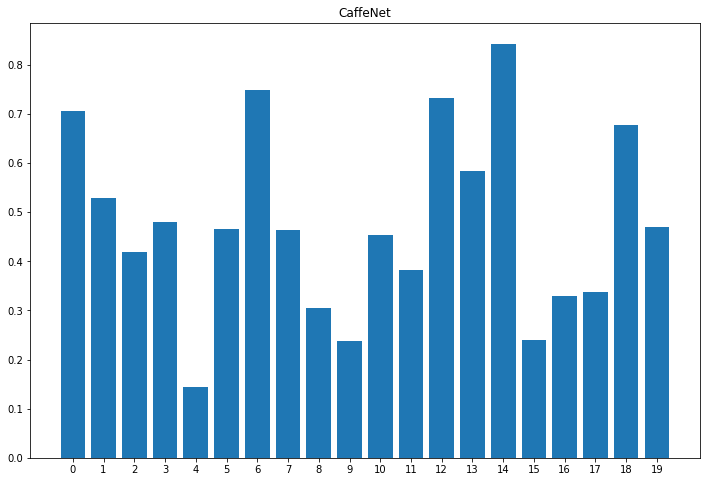

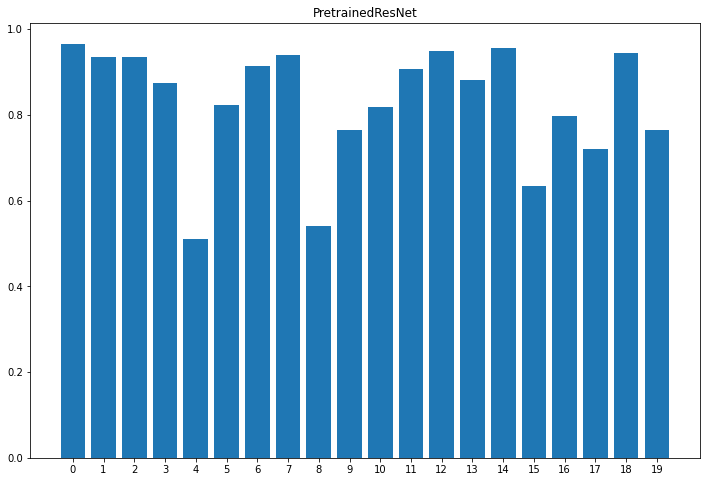

In [33]:
caffeCkpt = 'models/checkpoint-CaffeNet15-epoch75.pth'
device = torch.device("cuda")
caffenet = CaffeNet().to(device)
plot_AP(caffenet, caffeCkpt, 'CaffeNet')

resnetCkpt = 'models/checkpoint-PretrainedResNet2-epoch10.pth'
device = torch.device("cuda")
resnet = PretrainedResNet().to(device)
plot_AP(resnet, resnetCkpt, 'PretrainedResNet')